In [1]:
%matplotlib inline
import datacube
dc = datacube.Datacube(app='dc-example')
import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon
import rasterio
import shapely.geometry
import shapely.ops
from functools import partial
import pyproj
from datacube.model import CRS

from datacube.storage import masking
import pandas

In [2]:
def datasets_union(dss):
    return shapely.ops.unary_union([shapely.geometry.Polygon(ds.extent.to_crs(CRS('EPSG:4326')).points) for ds in dss])

In [3]:
def plot_folium(shapes):
    style_function = lambda x: {'fillColor': '#000000' if x['type'] == 'Polygon' else '#00ff00'}
    mapa = folium.Map(location=[-30,150], zoom_start=4)
    poly = folium.features.GeoJson(mapping(shapes), style_function=style_function)
    mapa.add_children(poly)
    display(mapa)

In [4]:
dc.list_products()

,name,description,platform,product_type,instrument,format,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,
24,h8_ahi_brf_granule,"H8 BRF, 2km, 1km and 500m granules",HIMAWARI_8,BRF,AHI,NETCDF,NaN,NaN,NaN,NaN
25,h8_ahi_obs_granule,"H8 OBS, 2km granules",HIMAWARI_8,OBS,AHI,NETCDF,NaN,NaN,NaN,NaN
26,h8_ahi_solar_granule,"H8 SOLAR GEOMETRY, 2km, 1km and 500m granules",HIMAWARI_8,GEOM_SOLAR,AHI,NETCDF,NaN,NaN,NaN,NaN
6,ls5_ledaps_scene,Landsat 5 LEDAPS 25 metre,LANDSAT_5,ledaps,TM,GeoTiff,NaN,NaN,NaN,NaN
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,LANDSAT_5,level1,TM,GeoTiff,NaN,NaN,NaN,NaN
3,ls5_nbar_scene,Landsat 5 NBAR 25 metre,LANDSAT_5,nbar,TM,GeoTiff,NaN,NaN,NaN,NaN
4,ls5_nbart_scene,Landsat 5 NBART 25 metre,LANDSAT_5,nbart,TM,GeoTiff,NaN,NaN,NaN,NaN
5,ls5_pq_scene,Landsat 5 PQ 25 metre,LANDSAT_5,pqa,TM,GeoTiff,NaN,NaN,NaN,NaN
1,ls5_satellite_telemetry_data,Landsat 5 Satellite Telemetry Data,LANDSAT_5,satellite_telemetry_data,TM,NaN,NaN,NaN,NaN,NaN


In [8]:
plot_folium(datasets_union(dc.index.datasets.search_eager(product='s2a_level1c_granule')))

In [18]:
#s2a_l1c = dc.load(product='s2a_level1c_albers_20',x=(147.36, 147.41), y=(-35.1, -35.15),)
s2a_l1c = dc.load(product='s2a_level1c_albers_20',x=(-180, 180), y=(-90, 90))

ValueError: cannot convert float NaN to integer

In [16]:
s2a_l1c.data_vars

Data variables:
    veg1           (time, y, x) int16 2271 1978 1961 1963 1898 1968 2071 ...
    veg2           (time, y, x) int16 2905 2945 2746 2764 2658 2705 2726 ...
    veg3           (time, y, x) int16 3617 3868 3696 3755 3681 3601 3527 ...
    snowicecloud1  (time, y, x) int16 3429 3296 3425 3399 3354 3428 3435 ...
    snowicecloud2  (time, y, x) int16 2357 2074 2102 2063 2059 2072 2159 ...

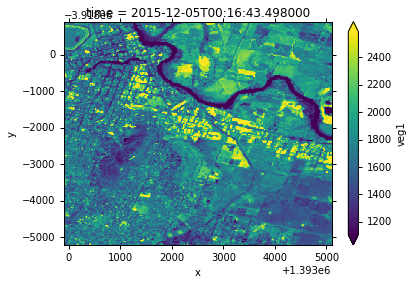

In [17]:
s2a_l1c.veg1.plot(robust='True')